# Protein Language Model basics

**Learning Objectives:**
- Tokenization of protein sequences

In [1]:
if 'google.colab' in str(get_ipython()):
    print("Running on Google Colab. Executing Colab-specific commands...")
    # Mount Google Drive to access files
    from google.colab import drive
    drive.mount('/content/drive')

    # Drive location for the fasta files
    data_loc = '/content/drive/My Drive/AIDrivenDesignOfBiologics/AIDrivenDesignOfBiologics-PEGSEurope-2025/ProteinLanguageModels'

    print("Installing dependencies...")
    !pip install biopython # pandas matplotlib seaborn tqdm transformers scipy torch torchvision torchaudio

else:
    print("Not running on Google Colab. Skipping Colab-specific commands.")
    print("Running in a local environment or Jupyter Notebook.")
    #data_loc = '/home/davidnannemann/AIDD4B/ProteinLMs/'

Running on Google Colab. Executing Colab-specific commands...
Mounted at /content/drive
Installing dependencies...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 45.6 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import random
import gc
from tqdm import tqdm
from Bio import SeqIO
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

# Model-specific imports
from transformers import AutoTokenizer, AutoModelForMaskedLM
from transformers.pipelines import pipeline
import torch
import torch.nn.functional as F

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

print("Dependencies loaded successfully!")

Dependencies loaded successfully!


# Model Loading

In [3]:
model_name = "Exscientia/IgBert"
print(f"Loading {model_name}...")

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForMaskedLM.from_pretrained(model_name)

Loading Exscientia/IgBert...


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt:   0%|          | 0.00/81.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/686 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

# Tokenization

Tokens are how the sequence is represented to a pLM.

Explore the token vocabulary for the loaded model. Models will use different vocabularies or other tokenization practices that must be implemented individually.

HuggingFace models provide a `tokenizer` function that provides the vocabulary and creates a vector of tokens from the provided sequence string.

In [4]:
# Show amino acid tokens specifically
standard_aa = "ACDEFGHIKLMNPQRSTVWY"
extended_aa = standard_aa + "BXZUO-."  # B, X, Z are sometimes used
extended_dict = {
    "B": "Asp or Asn",
    "X": "Any AA",
    "Z": "Glu or Gln",
    "U": "Selenocysteine",
    "O": "Pyrrolysine",
    "-": "Gap/Padding",
    ".": "Gap/Padding"
}

token_dict = tokenizer.get_vocab()
for token in token_dict.items():
    if token[0] in standard_aa:
        print(f"Token: {token[0]:>6}, Index: {token[1]:>3}")
    elif token[0] in extended_aa:
        print(f"Token: {token[0]:>6}, Index: {token[1]:>3} (non-standard: {extended_dict[token[0]]})")
    else:
        print(f"Token: {token[0]:>6}, Index: {token[1]:>3} (special)")


Token:      K, Index:  12
Token:      A, Index:   6
Token:      V, Index:   8
Token:      S, Index:  10
Token:      Y, Index:  20
Token:      G, Index:   7
Token:      X, Index:  25 (non-standard: Any AA)
Token:      Q, Index:  18
Token:      D, Index:  14
Token:      M, Index:  21
Token:      W, Index:  24
Token:  [SEP], Index:   3 (special)
Token:      U, Index:  26 (non-standard: Selenocysteine)
Token:      Z, Index:  28 (non-standard: Glu or Gln)
Token:      P, Index:  16
Token:  [CLS], Index:   2 (special)
Token:      O, Index:  29 (non-standard: Pyrrolysine)
Token:      L, Index:   5
Token:  [UNK], Index:   1 (special)
Token:      F, Index:  19
Token:      I, Index:  11
Token:      H, Index:  22
Token:      C, Index:  23
Token:      R, Index:  13
Token:      N, Index:  17
Token:      B, Index:  27 (non-standard: Asp or Asn)
Token:      E, Index:   9
Token:  [PAD], Index:   0 (special)
Token:      T, Index:  15
Token: [MASK], Index:   4 (special)


# Model Inputs and Outputs


Let's look at the sequence of cetuximab and predict the amino acid probabilities at positions of interest.

Find where in the code each step below is happening.

1. the position is masked and the sequence is formatted.
2. the tokens are then embedded into a high-dimensional embedding vector.
3. the output of the model is a vector of logits, one for each token. A logit is an unnormalized score. (Each pLM has a different set of tokens, sometimes including nucleotides and gaps, too.)
4. Probabilities are calculated from the logits using the softmax function.
5. The index for the top probability is found and a mapping to the order of the tokens is used to find the top amino acid. (Notice we extract the order of the tokens from the model, too)


In [5]:
# Choose a position to analyze (e.g., position 5 or 31 or 95)
sequence_position = 95  # position in the sequence (1-based index, as you would count from the N-terminus)
position = sequence_position -1 # 0-based index

# Define heavy and light chain sequences
heavy_sequence = 'QVQLKQSGPGLVQPSQSLSITCTVSGFSLTNYGVHWVRQSPGKGLEWLGVIWSGGNTDYNTPFTSRLSINKDNSKSQVFFKMNSLQSNDTAIYYCARALTYYDYEFAYWGQGTLVTVSA'
light_sequence = 'DILLTQSPVILSVSPGERVSFSCRASQSIGTNIHWYQQRTNGSPRLLIKYASESISGIPSRFSGSGSGTDFTLSINSVESEDIADYYCQQNNNWPTTFGAGTKLELK'

# The IgBERT model expects heavy and light chains to be combinded with a [SEP] token
seq_list = list(heavy_sequence) + ['[SEP]'] + list(light_sequence)

# Prepare masked sequence for the chosen position
native_aa = seq_list[position]
mask_token = "[MASK]"
seq_list[position] = mask_token

# BERT-based models expect space-separated tokens
masked_seq = ' '.join(seq_list)

# Tokenize and get model outputs
inputs = tokenizer(masked_seq, return_tensors="pt")
device = next(model.parameters()).device
inputs = {k: v.to(device) for k, v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs, output_hidden_states=True, labels=inputs["input_ids"], output_attentions=True)

# Find the mask token index in the input
mask_token_id = tokenizer.mask_token_id
mask_idx = (inputs["input_ids"][0] == mask_token_id).nonzero(as_tuple=True)[0].item()

BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


## Study the inputs

Prior to tokenization, the input is a string with formatting specific to each model, such as mask representation or tracking of chain breaks.

In [6]:
print(masked_seq)
print(type(masked_seq))

Q V Q L K Q S G P G L V Q P S Q S L S I T C T V S G F S L T N Y G V H W V R Q S P G K G L E W L G V I W S G G N T D Y N T P F T S R L S I N K D N S K S Q V F F K M N S L Q S N D T A I Y Y [MASK] A R A L T Y Y D Y E F A Y W G Q G T L V T V S A [SEP] D I L L T Q S P V I L S V S P G E R V S F S C R A S Q S I G T N I H W Y Q Q R T N G S P R L L I K Y A S E S I S G I P S R F S G S G S G T D F T L S I N S V E S E D I A D Y Y C Q Q N N N W P T T F G A G T K L E L K
<class 'str'>


Upon tokenization, the `input` is a tensor representation of the masked sequence with the index of each token at each position. The index corresponds to the tokens available for the model, such as amino acids and the `[MASK]` tokens. Find the index of the `[MASK]` token and see that it corresponds to your `position` variable. With some models, the tokenizer adds a `CLS` token at the beginning and a `SEP` token at the end.

In [7]:
print("Input tokens:", inputs['input_ids'])

Input tokens: tensor([[ 2, 18,  8, 18,  5, 12, 18, 10,  7, 16,  7,  5,  8, 18, 16, 10, 18, 10,
          5, 10, 11, 15, 23, 15,  8, 10,  7, 19, 10,  5, 15, 17, 20,  7,  8, 22,
         24,  8, 13, 18, 10, 16,  7, 12,  7,  5,  9, 24,  5,  7,  8, 11, 24, 10,
          7,  7, 17, 15, 14, 20, 17, 15, 16, 19, 15, 10, 13,  5, 10, 11, 17, 12,
         14, 17, 10, 12, 10, 18,  8, 19, 19, 12, 21, 17, 10,  5, 18, 10, 17, 14,
         15,  6, 11, 20, 20,  4,  6, 13,  6,  5, 15, 20, 20, 14, 20,  9, 19,  6,
         20, 24,  7, 18,  7, 15,  5,  8, 15,  8, 10,  6,  3, 14, 11,  5,  5, 15,
         18, 10, 16,  8, 11,  5, 10,  8, 10, 16,  7,  9, 13,  8, 10, 19, 10, 23,
         13,  6, 10, 18, 10, 11,  7, 15, 17, 11, 22, 24, 20, 18, 18, 13, 15, 17,
          7, 10, 16, 13,  5,  5, 11, 12, 20,  6, 10,  9, 10, 11, 10,  7, 11, 16,
         10, 13, 19, 10,  7, 10,  7, 10,  7, 15, 14, 19, 15,  5, 10, 11, 17, 10,
          8,  9, 10,  9, 14, 11,  6, 14, 20, 20, 23, 18, 18, 17, 17, 17, 24, 16,
         15, 1

## Outputs

In [8]:
# Use the transformers documentation to explore the outputs for this model type

# The output is a MaskedLMOutput object holding several attributes
print(type(outputs))

# Documentation link: https://huggingface.co/docs/transformers/v4.57.0/en/main_classes/output#transformers.modeling_outputs.MaskedLMOutput

# The parameters of the output object can be accessed as attributes in a dictionary-like format
print(outputs.keys())

<class 'transformers.modeling_outputs.MaskedLMOutput'>
odict_keys(['loss', 'logits', 'hidden_states', 'attentions'])


### Logits

In [9]:
# The output logits are a tensor of shape [1, sequence_length, vocab_size], where vocab_size is the number of tokens in
# the model's vocabulary. The logits represent the model's raw predictions for each token in the vocabulary at each
# position in the sequence.

print("Full output logits shape:", outputs.logits.shape)
print("Logits at first two positions:", outputs.logits[0, :2, :])  # Logits for the first 20 positions

Full output logits shape: torch.Size([1, 229, 30])
Logits at first two positions: tensor([[-22.1950, -22.8741, -22.7566, -21.0781, -21.1098,   0.5171,   1.2251,
          -0.0674,  -1.2335,  -2.4930,   3.0777,  -0.4932,  -2.1105,  -0.9502,
          -2.0450,  -0.7416,   0.9150,  -1.6172,  -0.8083,  -1.7620,  -3.5834,
          -3.3643,  -3.2955,  -4.4781,  -4.0276, -12.0215, -22.6492, -22.6690,
         -21.4005, -24.5775],
        [-21.2667, -19.6826, -20.4839, -20.0497, -21.6347,   1.0266,  -1.1811,
          -4.0154,  -1.1473,   0.4857,  -1.9740,  -4.8042,  -0.4012,  -0.8067,
          -3.0511,  -3.3349,   0.8568,  -2.5724,  14.3958,  -5.7251,  -3.9788,
          -3.9497,   4.4461,  -7.0227,  -6.1778,  -0.5212, -22.1918, -24.2562,
         -20.4278, -21.7460]])


In [10]:
# Get logits for the masked site
logits = outputs.logits[0, mask_idx, :]

# AA logits for the masked position.
print("Shape:", logits.shape,". One logit for each token in the vocabulary.")

# Get token indices for the 20 standard amino acids.
# Find the logits for those tokens at the respective index.
# There are other code mechanisms to do this, but this is straightforward.
aa_order = list("ACDEFGHIKLMNPQRSTVWY")
aa_token_ids = [tokenizer.convert_tokens_to_ids(aa) for aa in aa_order] # logit indices for standard AAs in aa_order
aa_logits = logits[aa_token_ids] # logits ordered as in aa_order

print("Logits values:", aa_logits.cpu().numpy())


Shape: torch.Size([30]) . One logit for each token in the vocabulary.
Logits values: [-1.2194014   9.93904    -2.2883673  -3.632898    1.2727065   2.547009
 -3.4888868  -3.0121665  -4.4184136  -0.5170951  -4.0587935  -2.580739
 -3.3579657  -3.5923038   1.0884349   1.5840315  -2.9378564  -0.02956572
  3.2069583   2.4769497 ]


In [11]:
# Probabilities are calculated using softmax on the logits and should sum to 1.
aa_probs = F.softmax(aa_logits, dim=0).cpu().numpy()

print("Sum of probabilities (should be 1):", aa_probs.sum())
print("\n")
for aa, prob, logits in zip(aa_order, aa_probs, aa_logits):
    print(f"Amino Acid: {aa}, Probability: {prob:.3f}, Logit: {logits.item():.4f}")
print("\n")

# Show probabilities and native/best amino acids
best_aa = aa_order[aa_probs.argmax()]
print(f"At position {sequence_position} (index {position}): Native AA = {native_aa}; Probability = {round(float(aa_probs[aa_order.index(native_aa)]),3)}")
print(f"At position {sequence_position} (index {position}):   Best AA = {best_aa}; Probability = {round(float(aa_probs[aa_order.index(best_aa)]),3)}")

Sum of probabilities (should be 1): 1.0000001


Amino Acid: A, Probability: 0.000, Logit: -1.2194
Amino Acid: C, Probability: 0.997, Logit: 9.9390
Amino Acid: D, Probability: 0.000, Logit: -2.2884
Amino Acid: E, Probability: 0.000, Logit: -3.6329
Amino Acid: F, Probability: 0.000, Logit: 1.2727
Amino Acid: G, Probability: 0.001, Logit: 2.5470
Amino Acid: H, Probability: 0.000, Logit: -3.4889
Amino Acid: I, Probability: 0.000, Logit: -3.0122
Amino Acid: K, Probability: 0.000, Logit: -4.4184
Amino Acid: L, Probability: 0.000, Logit: -0.5171
Amino Acid: M, Probability: 0.000, Logit: -4.0588
Amino Acid: N, Probability: 0.000, Logit: -2.5807
Amino Acid: P, Probability: 0.000, Logit: -3.3580
Amino Acid: Q, Probability: 0.000, Logit: -3.5923
Amino Acid: R, Probability: 0.000, Logit: 1.0884
Amino Acid: S, Probability: 0.000, Logit: 1.5840
Amino Acid: T, Probability: 0.000, Logit: -2.9379
Amino Acid: V, Probability: 0.000, Logit: -0.0296
Amino Acid: W, Probability: 0.001, Logit: 3.2070
Amino Ac

Let's understand the relationship between logits and probabilities with a plot, and visualize the best amino acid at the position of interest.

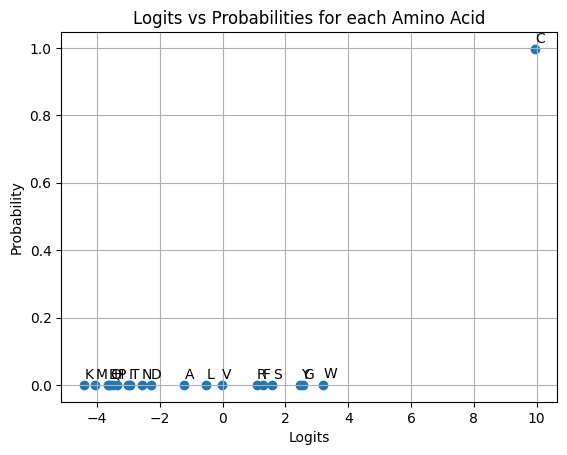

In [12]:
x,y = aa_logits.cpu().numpy(), aa_probs
plt.scatter(x, y)

# Annotate each point
for i, txt in enumerate(aa_order):
    plt.annotate(txt, (x[i], y[i]), # xy is the point to annotate
                 xytext=(x[i] + 0.01, y[i] + 0.01), # xytext is the text position
                 textcoords="data", # coordinate system for xytext
                 ha='left', va='bottom') # horizontal and vertical alignment

plt.xlabel("Logits")
plt.ylabel("Probability")
plt.title("Logits vs Probabilities for each Amino Acid")
plt.grid(True)
plt.show()

Cycle back and look at other positions. I recommend looking at residues 5 or 30 or 104, as these are interesting (hint, hint). Unless changed, the example sequence is an antibody, so look in the range 24-34 and 98-108, as these are CDR1 and CDR3.

For each position, consider if the native amino acid is recommended at that site or if the optimal identity is another amino acid.

### Loss

In [13]:
print(outputs.loss)

tensor(0.4177)


### Hidden States

The hidden states, or embeddings, are the underlying representation of the masked sequence position, capturing contextual information. Embedding dimension is a property of the model, associated with the parameters of its architecture. An embedding can be extracted from each layer of the model; the final layer is frequently utilized, but other layers are known to have meaningful information.


In [14]:
print(len(outputs.hidden_states)) # Number of layers + input embeddings
print(outputs.hidden_states[-1].shape)  # Shape of the hidden state from the last layer

31
torch.Size([1, 229, 1024])


In [15]:
# Get embedding for the masked site
embedding = outputs.hidden_states[-1][0, mask_idx, :].cpu().numpy()

print("Embedding shape:", embedding.shape)

Embedding shape: (1024,)


### Attention

In [16]:
print(len(outputs.attentions)) # One attention tensor per layer
print(outputs.attentions[0].shape)  # Shape of the attention from the first layer
# Each attention tensor has shape (batch_size, num_heads, seq_length, seq_length)
# This represents the attention weights from each head in the layer to every position in the sequence.
# For example, outputs.attentions[0][0, 0] gives the attention weights from the first head of the first layer for the first sequence in the batch.

30
torch.Size([1, 16, 229, 229])


# Whole-of-protein analyses

### Position probabilities using the `pipeline` function

In [17]:
def create_masked_input(heavy_chain, light_chain, heavy_position=None, light_position=None, mask_token = "[MASK]"):
    """
    Create a masked sequence input for the model by masking the amino acid at the specified position.
    """

    # The IgBERT model expects heavy and light chains to be combinded with a [SEP] token
    heavy_seq_list = list(heavy_sequence)
    light_seq_list = list(light_sequence)

    if not heavy_position == None:
        heavy_seq_list[heavy_position] = mask_token
    if not light_position == None:
        light_seq_list[light_position] = mask_token

    masked_sequence = heavy_seq_list + ['[SEP]'] + light_seq_list

    return ' '.join(masked_sequence)

def get_positionwise_probs(model_pipeline, heavy_chain, light_chain):
    """
    For each position, mask it and get the probability for all 20 amino acids.
    Returns: probs_matrix (L x 20), aa_order (list), native_indices (list)
    """
    aa_order = list("ACDEFGHIKLMNPQRSTVWY")
    probs_matrix = []
    native_indices = []

    for pos in range(len(heavy_chain)):
        masked_seq = create_masked_input(heavy_chain, light_chain, heavy_position=pos, light_position=None)
        native_aa = heavy_chain[pos]
        native_indices.append(aa_order.index(native_aa) if native_aa in aa_order else -1)

        # Get predictions for this mask
        results = model_pipeline(masked_seq)

        # results: list of dicts, each with 'token_str' and 'score'
        aa_probs = np.zeros(20)
        for res in results:
            aa = res['token_str'].strip().upper()
            if aa in aa_order:
                aa_probs[aa_order.index(aa)] = res['score']
        probs_matrix.append(aa_probs)
    for pos in range(len(light_chain)):
        masked_seq = create_masked_input(heavy_chain, light_chain, heavy_position=None, light_position=pos)
        native_aa = light_chain[pos]
        native_indices.append(aa_order.index(native_aa) if native_aa in aa_order else -1)

        results = model_pipeline(masked_seq)
        aa_probs = np.zeros(20)
        for res in results:
            aa = res['token_str'].strip().upper()
            if aa in aa_order:
                aa_probs[aa_order.index(aa)] = res['score']
        probs_matrix.append(aa_probs)

    probs_matrix = np.array(probs_matrix)  # shape: (L, 20)
    return probs_matrix, aa_order, native_indices

model_pipeline = pipeline("fill-mask",
                          model=model,
                          tokenizer=tokenizer,
                          device=0 if torch.cuda.is_available() else -1)

probs_matrix, aa_order, native_indices = get_positionwise_probs(model_pipeline, heavy_sequence, light_sequence)

Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


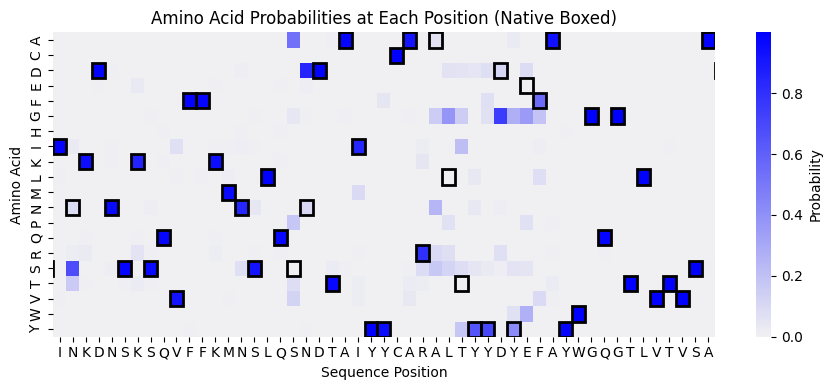

Display of a full sequence can be difficult. Set limits on the x-axis to "zoom in" on parts of the plot. 


In [18]:
# Plotting the heatmap
plt.figure(figsize=(9, 4))
palette = sns.color_palette("light:b", as_cmap=True)

ax = sns.heatmap(probs_matrix.T, cmap=palette, xticklabels=list(heavy_sequence+light_sequence), yticklabels=aa_order, cbar_kws={'label': 'Probability'})

# Highlight native residue at each position
for i, aa_idx in enumerate(native_indices):
    if aa_idx >= 0:
       ax.add_patch(plt.Rectangle((i, aa_idx), 1, 1, fill=False, edgecolor='black', lw=2))

#plt.xlim((0,55))
plt.xlim((68,119))
plt.xticks(rotation=0)
plt.xlabel("Sequence Position")
plt.ylabel("Amino Acid")
plt.title("Amino Acid Probabilities at Each Position (Native Boxed)")
plt.tight_layout()
plt.show()

print('Display of a full sequence can be difficult. Set limits on the x-axis to "zoom in" on parts of the plot. ')

# Extracting position probabilities with ProteinMPNN


In [19]:
import sys, os
if 'google.colab' in str(get_ipython()):
  if not os.path.isdir("ProteinMPNN"):
    os.system("git clone -q https://github.com/dauparas/ProteinMPNN.git")
  sys.path.append('/content/ProteinMPNN')
  mpnn_dir = '/content/ProteinMPNN'
else:
  mpnn_dir = '/home/davidnannemann/git_repositories/ProteinMPNN'
  sys.path.append('/home/davidnannemann/git_repositories/ProteinMPNN')

from protein_mpnn_utils import parse_PDB, tied_featurize
from protein_mpnn_utils import ProteinMPNN

In [20]:
def load_model(model_path=f'{mpnn_dir}/vanilla_model_weights/v_48_020.pt'):
    """Load ProteinMPNN model."""
    checkpoint = torch.load(model_path, map_location='cpu')
    model = ProteinMPNN(
        num_letters=21,
        node_features=128,
        edge_features=128,
        hidden_dim=128,
        num_encoder_layers=3,
        num_decoder_layers=3,
        vocab=21,
        k_neighbors=checkpoint['num_edges']
    )
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    return model

model = load_model()

In [21]:
def get_all_probabilities(model, pdb_path, use_backbone_only=False):
    """Extract amino acid probabilities for each position."""
    gc.collect()
    # Parse PDB file
    pdb_dict_list = parse_PDB(pdb_path)
    pdb_dict = pdb_dict_list[0]

    # Featurize
    batch = tied_featurize([pdb_dict], None, None, None, None)

    X = batch[0]
    S = batch[1]
    mask = batch[2]
    chain_M = batch[4]
    chain_encoding_all = batch[5]
    chain_M_pos = batch[10]
    residue_idx = batch[12]

    # Random noise for conditional probs (required by the function but not critically important)
    randn_1 = torch.randn(chain_M.shape, device=X.device)
    # Get logits from model
    with torch.no_grad():

        # METHOD 1: AUTOREGRESSIVE (standard model call)
        # Predicts sequentially: P(AA_i | structure, AA_1, ..., AA_{i-1})
        # This is the actual design mode - each position depends on previous predictions
        # The order matters! Results change if you decode in a different order.
        # METHOD 2: CONDITIONAL (given the native sequence)
        # Predicts: P(AA_i | structure, all other native amino acids)
        # Uses the actual sequence context - good for scoring how well each residue fits
        # If use_backbone_only=True, only uses backbone geometry
        # If use_backbone_only=False, also uses side chain information in graph
        # METHOD 3: UNCONDITIONAL (structure only)
        # Predicts: P(AA_i | structure) independently for each position
        # No sequence context at all - pure structure-to-sequence mapping
        # All positions predicted in parallel (much faster!)
        # Shows which amino acids "fit" the local backbone geometry

        print(f"Starting autoregressive...")
        log_probs_autoregressive = model(X, S, mask, chain_M*mask, residue_idx, chain_encoding_all, randn_1)
        probs_autoregressive = torch.exp(log_probs_autoregressive).squeeze(0).numpy()
        print("✓ Autoregressive complete")

        print(f"Starting conditional...")
        log_probs_conditional = model.conditional_probs(
            X, S, mask, chain_M*chain_M_pos, residue_idx, chain_encoding_all,
            randn_1, use_backbone_only
        )
        probs_conditional = torch.exp(log_probs_conditional).squeeze(0).numpy()
        print("✓ Conditional complete")

        print(f"Starting unconditional...")
        log_probs_unconditional = model.unconditional_probs(
            X, mask, residue_idx, chain_encoding_all
        )
        probs_unconditional = torch.exp(log_probs_unconditional).squeeze(0).numpy()
        print("✓ Unconditional complete")

    return {
        'autoregressive': probs_autoregressive,
        'conditional': probs_conditional,
        'unconditional': probs_unconditional,
        'sequence': pdb_dict['seq']
    }

pdb_path = f"{data_loc}/pLM_basics_and_benchmarking/5th2A.pdb"
print(f"Processing structure: {pdb_path}")
probs_dict = get_all_probabilities(model, pdb_path, use_backbone_only=True)


Processing structure: /content/drive/My Drive/AIDrivenDesignOfBiologics/AIDrivenDesignOfBiologics-PEGSEurope-2025/ProteinLanguageModels/pLM_basics_and_benchmarking/5th2A.pdb


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/My Drive/AIDrivenDesignOfBiologics/AIDrivenDesignOfBiologics-PEGSEurope-2025/ProteinLanguageModels/pLM_basics_and_benchmarking/5th2A.pdb'

In [22]:
def plot_heatmap(probs, sequence, output_path='aa_probabilities.png'):
    """Plot heatmap of amino acid probabilities."""
    # Amino acids in alphabetical order (20 standard + X for unknown)
    aa_order = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
                'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', 'X']

    native_indices = [aa_order.index(aa) for aa in sequence]

    # Remove the last column if it's the unknown/mask token
    if probs.shape[1] == 21:
        probs = probs[:, :20]
        aa_order = aa_order[:20]

    # Create figure
    fig, ax = plt.subplots(figsize=(max(12, len(sequence)/5), 8))

    # Plot heatmap
    sns.heatmap(probs.T,
                cmap='YlOrRd',
                xticklabels=list(sequence),
                yticklabels=aa_order,
                cbar_kws={'label': 'Probability'},
                ax=ax)

    for i, aa_idx in enumerate(native_indices):
        if aa_idx >= 0:
           ax.add_patch(plt.Rectangle((i, aa_idx), 1, 1, fill=False, edgecolor='black', lw=2))

    ax.set_xlabel('Position', fontsize=12)
    ax.set_ylabel('Amino Acid', fontsize=12)
    ax.set_title('ProteinMPNN Amino Acid Probabilities', fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"Heatmap saved to {output_path}")
    plt.show()
def plot_comparison_heatmaps(probs_dict, output_path='aa_probabilities_comparison.png'):
    """Plot side-by-side heatmaps comparing all three methods."""
    sequence = probs_dict['sequence']

    # Amino acids in alphabetical order (20 standard AAs)
    aa_order = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
                'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

    # Create figure with three subplots
    fig, axes = plt.subplots(4, 1, figsize=(max(14, len(sequence)/4), 18))

    methods = [
        ('unconditional', 'Unconditional: P(AA | structure only)'),
        ('conditional', 'Conditional: P(AA | structure + native sequence)'),
        ('autoregressive', 'Autoregressive: P(AA | structure + previous AAs)'),
        ('pLM', 'IgBERT')
    ]

    for idx, (method, title) in enumerate(methods):
        probs = probs_dict[method]

        # Remove unknown/mask token column if present
        if probs.shape[1] == 21:
            probs = probs[:, :20]

        # Plot heatmap
        sns.heatmap(probs.T,
                    cmap='YlOrRd',
                    xticklabels=list(sequence),
                    yticklabels=aa_order,
                    cbar_kws={'label': 'Probability'},
                    ax=axes[idx],
                    vmin=0, vmax=1)

        axes[idx].set_xlabel('Position', fontsize=11)
        axes[idx].set_ylabel('Amino Acid', fontsize=11)
        axes[idx].set_title(title, fontsize=12, fontweight='bold', pad=10)

    plt.suptitle('ProteinMPNN: Comparison of Probability Extraction Methods',
                 fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"Comparison heatmap saved to {output_path}")
    plt.show()

probs_dict['pLM'] = probs_matrix
#plot_heatmap(probs_dict['autoregressive'], probs_dict['sequence'])
plot_comparison_heatmaps(probs_dict)

NameError: name 'probs_dict' is not defined

In [ ]:
def print_probability_analysis(probs_dict, num_positions=5):
    """Print detailed comparison of top predictions for first few positions."""
    sequence = probs_dict['sequence']
    aa_list = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
               'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

    print(f"\n{'='*80}")
    print(f"COMPARISON: Top 3 predictions for first {num_positions} positions")
    print(f"{'='*80}\n")

    for i in range(min(num_positions, len(sequence))):
        print(f"Position {i+1} (Native: {sequence[i]})")
        print(f"{'-'*80}")

        for method in ['unconditional', 'conditional', 'autoregressive', 'pLM']:
            probs = probs_dict[method][i, :20]
            top_idx = np.argsort(probs)[-3:][::-1]
            top_aa = [aa_list[j] for j in top_idx]
            top_probs = [probs[j] for j in top_idx]

            # Check if native AA is in top 3
            native_prob = probs[aa_list.index(sequence[i])]
            native_rank = np.sum(probs > native_prob) + 1

            print(f"  {method:15s}: {top_aa[0]}({top_probs[0]:.3f})  "
                  f"{top_aa[1]}({top_probs[1]:.3f})  {top_aa[2]}({top_probs[2]:.3f})  "
                  f"| Native rank: {native_rank} (p={native_prob:.3f})")
        print()

print_probability_analysis(probs_dict, num_positions=50)


Consider whether a design strategy that uses multiple methods would be useful. Indeed, numerous reports indicated ensembling of outputs across models via averaging or jury vote performs well. See, for example, the Efficient Evolution process.